# Estratégia "Um Contra Todos" para Classificação de Dígitos

Para construir um classificador para os quatro dígitos contidos na base, utiliza-se a estratégia **"Um Contra Todos"** (*One-vs-All*).

## Passo a Passo

1. **Escolha de um dígito positivo**  
   Inicialmente, escolhe-se um dígito específico (por exemplo, **0**) para ser a classe **𝑦 = +1**.

2. **Agrupamento dos demais dígitos**  
   Todos os outros dígitos (por exemplo, **1, 4 e 5**) são temporariamente definidos como a classe **𝑦 = −1**.

3. **Treinamento do modelo**  
   O modelo é treinado para distinguir o dígito escolhido (**positivo**) de todos os outros (**negativos**).

4. **Repetição para cada dígito**  
   O processo é repetido para cada dígito que se deseja classificar. Assim, teremos um classificador separado para cada número.

## Exemplo de Transformação

Se o conjunto de rótulos originais for:



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Perceptron, LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin

# Funções

## funçoes de treinamento

In [2]:
class OneVsAllClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_clf):
        self.base_clf = base_clf
        self.classifiers = {}
        self.classes_ = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        for cls in self.classes_[:-1]:  # até o penúltimo (último é o "resto")
            y_bin = np.where(y == cls, 1, -1)
            clf = self.base_clf()
            clf.fit(X, y_bin)
            self.classifiers[cls] = clf
        return self

    def predict(self, X):
        y_pred = np.full(X.shape[0], self.classes_[-1])  # default = última classe
        for cls in self.classes_[:-1]:
            pred_bin = self.classifiers[cls].predict(X)
            mask = (pred_bin == 1)
            y_pred[mask] = cls
        return y_pred


# Por que criar duas funções para “Um Contra Todos”?

No projeto de classificação dos dígitos usando a estratégia **“Um Contra Todos”**, precisou-se criar duas funções separadas devido às diferenças fundamentais entre os modelos utilizados: **Regressão Linear** versus **Perceptron / Regressão Logística**.

---

## Regressão Linear

- **Saída do modelo:** valores contínuos (float), que podem assumir qualquer valor real.
- **Problema:** não fornece diretamente classes discretas (+1/-1).
- **Solução:** aplicar um **limiar (threshold)** para converter a saída contínua em classe binária


##  Perceptron e Regressão Logística

- **Saída do modelo:** classes discretas (+1 ou -1) diretamente.

- **Vantagem:** não precisa de threshold, pois o próprio predict() retorna a decisão binária.

In [3]:
def treinar_um_contra_todos(classificador, X_train, y_train, X_test, y_test):
    """
    Treina classificadores no esquema Um-Contra-Todos (One-vs-All)
    para os dígitos 0, 1 e 4. Retorna os classificadores e previsões.
    """
    digitos_alvo = [0, 1, 4]
    classificadores = {}

    for idx, digito in enumerate(digitos_alvo):
        y_bin = np.where(y_train == digito, 1, -1)
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        clf = classificador()
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    # Predição
    previsoes = []
    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        if pred is None:
            pred = 5
        previsoes.append(pred)

    print(f"\nModelo: {classificador.__name__}")
    print(classification_report(y_test, previsoes, digits=2))

    return classificadores, previsoes


In [4]:
def treinar_um_contra_todos_linear(X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4]):

    classificadores = {}

    # Treinamento de cada classificador binário
    for idx, digito in enumerate(digitos_alvo):
        # Rótulos binários: +1 para digito alvo, -1 para os demais
        y_bin = np.where(y_train == digito, 1, -1)

        if idx > 0:
            # Remover amostras do dígito anterior
            mask = y_train != digitos_alvo[idx-1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        # Escalonamento
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        # Treinamento do LinearRegression
        clf = LinearRegression()
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    # Predição no conjunto de teste
    previsoes = []
    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            y_cont = clf.predict(x_scaled)[0]
            if y_cont >= 0:  # limiar zero para decidir +1 / -1
                pred = digito
                break
        if pred is None:
            pred = 5  # nenhum classificador respondeu positivo
        previsoes.append(pred)

    print("=== Relatório de classificação Linear ===")
    print(classification_report(y_test, previsoes, digits=2))

    return classificadores, previsoes


## Funçoes de plotagem

In [5]:
def plot_um_contra_todos(classificadores, X, y, digitos_alvo=[0,1,4]):

    # Cores para os pontos
    cores_pontos = {0:'red', 1:'blue', 4:'green', 5:'orange'}

    plt.figure(figsize=(10,8))

    # Plotar os pontos
    for digito in np.unique(y):
        mask = y == digito
        plt.scatter(X[mask, 0], X[mask, 1],
                    c=cores_pontos[digito], edgecolors='k', alpha=0.6,
                    label=f'Dígito {digito}')

    # Criar grid para as fronteiras
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))

    # Plotar a fronteira de cada classificador binário
    cores_linhas = {0:'red', 1:'blue', 4:'green'}
    for digito, (modelo, scaler) in classificadores.items():
        grid_points = np.c_[xx.ravel(), yy.ravel()]
        grid_scaled = scaler.transform(grid_points)
        Z = modelo.predict(grid_scaled)
        Z = Z.reshape(xx.shape)
        # Apenas a linha da fronteira (onde Z muda de -1 para 1)
        plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
                    linestyles='--', linewidths=2,
                    label=f'Fronteira {digito} vs todos')

    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title("Fronteiras de decisão - Um Contra Todos")
    plt.legend()
    plt.show()

In [6]:
def plot_um_contra_todos_linear(classificadores, X, y, digitos_alvo=[0,1,4]):

    # Cores para cada classe
    cores_pontos = {0:'red', 1:'blue', 4:'green', 5:'orange'}
    cores_linha = {0:'red', 1:'blue', 4:'green'}

    plt.figure(figsize=(10,8))

    # Pontos de treino
    for digito in np.unique(y):
        mask = y == digito
        plt.scatter(X[mask,0], X[mask,1], 
                    c=cores_pontos[digito], edgecolors='k', alpha=0.6,
                    label=f'Dígito {digito}')

    # Criar grid
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Inicializa como dígito 5
    Z = np.full(grid_points.shape[0], 5)
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        y_cont = modelo.predict(grid_scaled)
        mask = y_cont >= 0
        Z[mask] = digito

    Z = Z.reshape(xx.shape)

    # Plotar linhas de fronteira de cada classificador
    for digito, (modelo, scaler) in classificadores.items():
        grid_scaled = scaler.transform(grid_points)
        y_cont = modelo.predict(grid_scaled).reshape(xx.shape)
        plt.contour(xx, yy, y_cont, levels=[0], colors=cores_linha[digito],
                    linestyles='--', linewidths=2)

    plt.xlabel("Intensidade")
    plt.ylabel("Simetria")
    plt.title("Fronteiras de decisão - Regressão Linear (Um Contra Todos)")
    plt.legend()
    plt.show()


# Separando os Dados


In [7]:
train = pd.read_csv('dataset/train_redu.csv')
test = pd.read_csv('dataset/test_redu.csv')

In [8]:
# Junta treino e teste caso queira embaralhar e dividir novamente
df = pd.concat([train, test], ignore_index=True)

# Filtra apenas dígitos 0, 1, 4 e 5
df = df[df['label'].isin([0, 1, 4, 5])]

# Separa features (X) e rótulos (y)
X = df.drop(columns=['label']).values
y = df['label'].values

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       193
           1       1.00      1.00      1.00       270
           4       0.90      0.93      0.91       268
           5       0.92      0.89      0.90       260

    accuracy                           0.95       991
   macro avg       0.95      0.95      0.95       991
weighted avg       0.95      0.95      0.95       991



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],


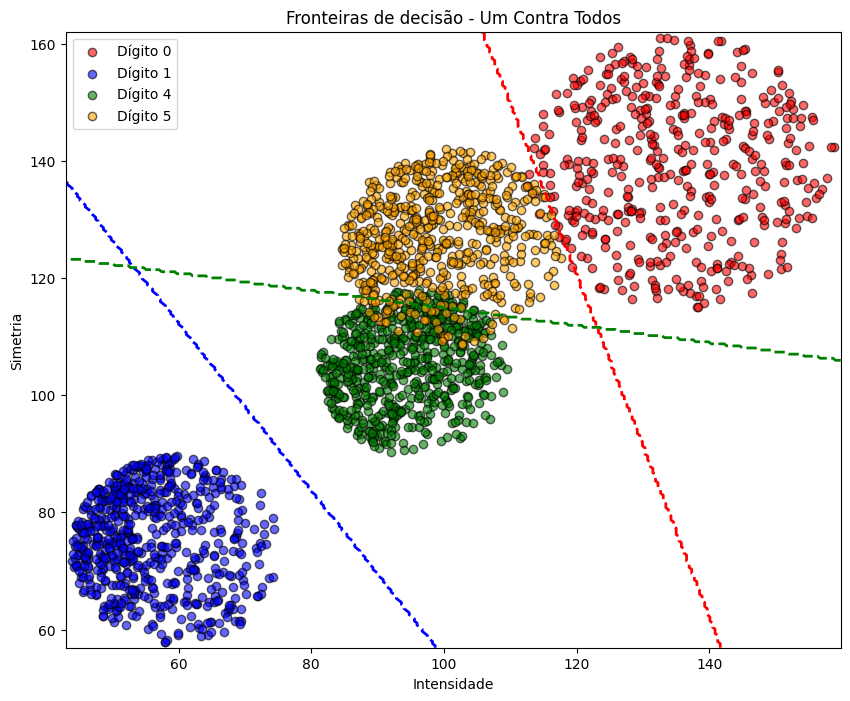

In [9]:

classificadores, previsoes = treinar_um_contra_todos(LogisticRegression, X_train, y_train, X_test, y_test)


plot_um_contra_todos(classificadores, X_train, y_train)





Modelo: Perceptron
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       193
           1       1.00      1.00      1.00       270
           4       1.00      0.65      0.79       268
           5       0.73      0.97      0.83       260

    accuracy                           0.90       991
   macro avg       0.92      0.90      0.90       991
weighted avg       0.92      0.90      0.89       991



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],


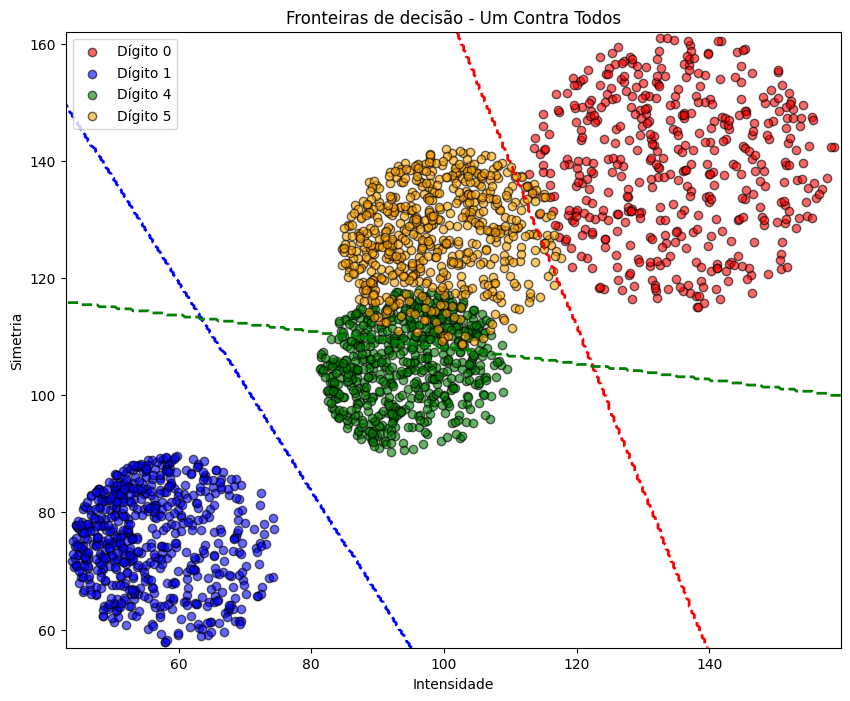

In [10]:

classificadores, previsoes = treinar_um_contra_todos(Perceptron, X_train, y_train, X_test, y_test)

plot_um_contra_todos(classificadores, X_train, y_train)

=== Relatório de classificação Linear ===
              precision    recall  f1-score   support

           0       1.00      0.79      0.88       193
           1       1.00      1.00      1.00       270
           4       0.88      0.97      0.92       268
           5       0.82      0.86      0.84       260

    accuracy                           0.91       991
   macro avg       0.92      0.90      0.91       991
weighted avg       0.92      0.91      0.91       991



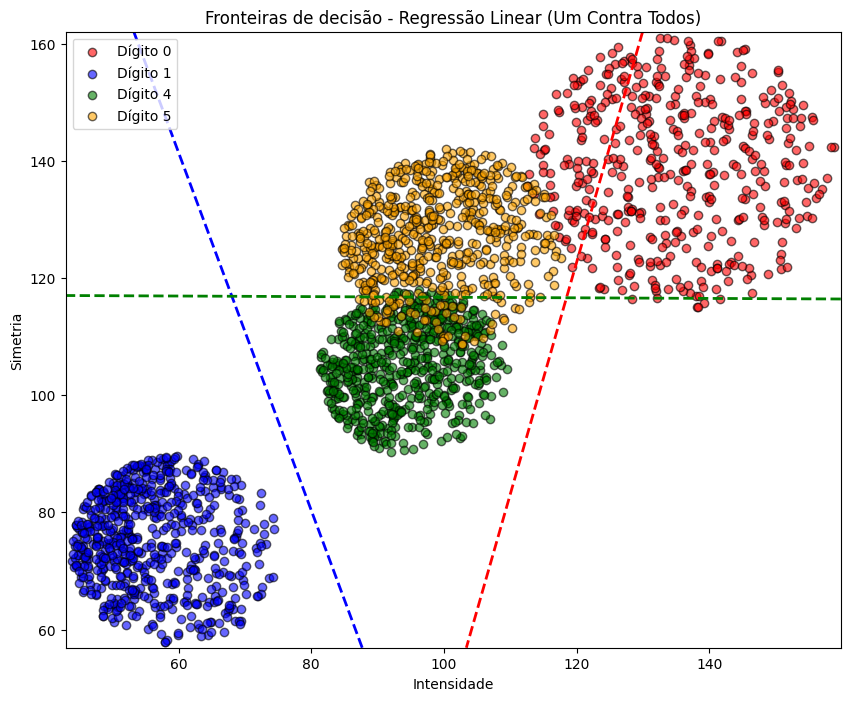

In [11]:

classificadores_lr, preds_lr = treinar_um_contra_todos_linear(X_train, y_train, X_test, y_test)


plot_um_contra_todos_linear(classificadores_lr, X_train, y_train)


# Implementações avançadas

## Predição com weight decay

In [12]:
def treinar_um_contra_todos_logistica_L2(X_train, y_train, X_test, y_test, lambda_=0.01):

    digitos_alvo = [0, 1, 4]
    classificadores = {}

    for idx, digito in enumerate(digitos_alvo):
        # Cria rótulos binários: +1 para alvo, -1 para os outros
        y_bin = np.where(y_train == digito, 1, -1)

        # Remove amostras do dígito anterior 
        if idx > 0:
            mask = y_train != digitos_alvo[idx - 1]
            X_train_filtrado = X_train[mask]
            y_bin = y_bin[mask]
        else:
            X_train_filtrado = X_train

        # Escalonamento
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_filtrado)

        # Treinar o classificador logístico com L2
        clf = LogisticRegression(
            penalty="l2",
            C=1/lambda_,       
            solver="lbfgs",
            max_iter=1000
        )
        clf.fit(X_train_scaled, y_bin)

        classificadores[digito] = (clf, scaler)

    # Predição sobre os dados de teste
    previsoes = []
    for x in X_test:
        pred = None
        for digito, (clf, scaler) in classificadores.items():
            x_scaled = scaler.transform([x])
            if clf.predict(x_scaled)[0] == 1:
                pred = digito
                break
        if pred is None:
            pred = 5  # fallback caso nenhum classificador responda positivo
        previsoes.append(pred)

    # Relatório de classificação
    print(f"\nRegressão Logística (L2, λ={lambda_})")
    print(classification_report(y_test, previsoes, digits=2))

    return classificadores, previsoes

In [13]:

# Logística com weight decay
clf_l, preds_l = treinar_um_contra_todos_logistica_L2( X_train, y_train, X_test, y_test)




Regressão Logística (L2, λ=0.01)
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       193
           1       1.00      1.00      1.00       270
           4       0.90      0.93      0.92       268
           5       0.92      0.89      0.90       260

    accuracy                           0.95       991
   macro avg       0.95      0.95      0.95       991
weighted avg       0.95      0.95      0.95       991



In [14]:
# comparando o resultado

classificadores, previsoes = treinar_um_contra_todos(LogisticRegression, X_train, y_train, X_test, y_test)


Modelo: LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       193
           1       1.00      1.00      1.00       270
           4       0.90      0.93      0.91       268
           5       0.92      0.89      0.90       260

    accuracy                           0.95       991
   macro avg       0.95      0.95      0.95       991
weighted avg       0.95      0.95      0.95       991



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17892\3751557393.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, Z, levels=[0], colors=cores_linhas[digito],


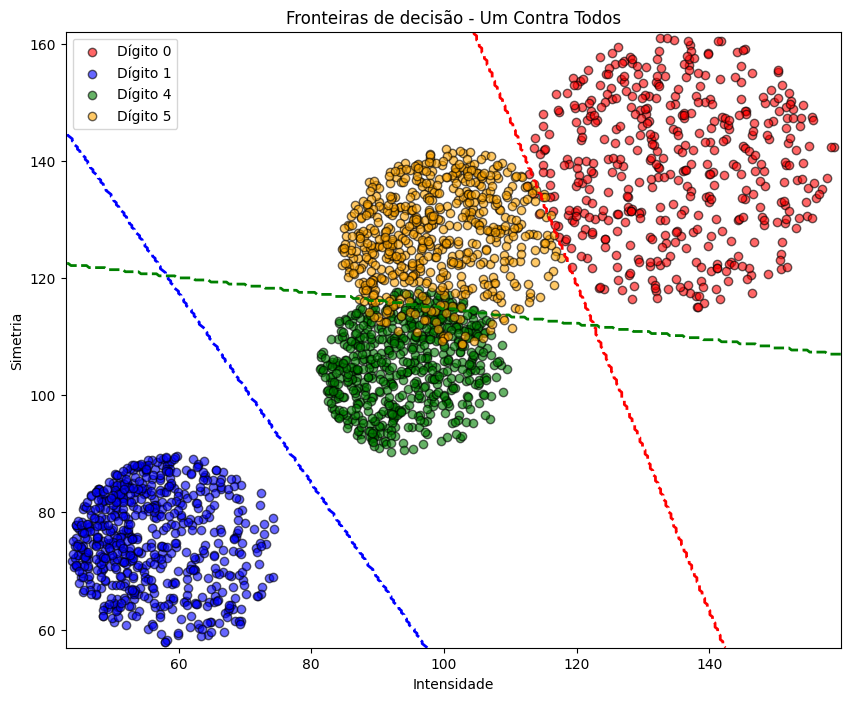

In [15]:
plot_um_contra_todos(clf_l, X_train, y_train)

## Melhor ordem de teste

In [16]:
import itertools

In [17]:
def melhor_ordem_um_contra_todos(classificador, X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4], digito_residual=5):
    melhor_ordem = None
    melhor_acuracia = 0
    melhor_classificadores = None
    melhor_previsoes = None
    
    # Todas as permutações possíveis
    for ordem in itertools.permutations(digitos_alvo):
        # Treina os classificadores nessa ordem
        classificadores = {}
        for idx, digito in enumerate(ordem):
            y_bin = np.where(y_train == digito, 1, -1)
            if idx > 0:
                mask = y_train != ordem[idx - 1]
                X_train_filtrado = X_train[mask]
                y_bin = y_bin[mask]
            else:
                X_train_filtrado = X_train

            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_filtrado)

            clf = classificador()
            clf.fit(X_train_scaled, y_bin)
            classificadores[digito] = (clf, scaler)

        # Predição com a lógica da ordem
        previsoes = []
        for x in X_test:
            pred = None
            for digito, (clf, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if clf.predict(x_scaled)[0] == 1:
                    pred = digito
                    break
            if pred is None:
                pred = digito_residual
            previsoes.append(pred)

        acuracia = accuracy_score(y_test, previsoes)
        if acuracia > melhor_acuracia:
            melhor_acuracia = acuracia
            melhor_ordem = ordem
            melhor_classificadores = classificadores
            melhor_previsoes = previsoes

    print(f"Melhor ordem: {melhor_ordem}")
    print(f"Acurácia máxima: {melhor_acuracia:.4f}")
    return melhor_ordem, melhor_classificadores, melhor_previsoes

In [18]:
def melhor_ordem_linear(X_train, y_train, X_test, y_test, digitos_alvo=[0,1,4], digito_fallback=5):

    from itertools import permutations
    
    melhor_acuracia = -1
    melhor_ordem = None
    melhores_classificadores = None
    melhores_previsoes = None
    
    # Testa todas as permutações possíveis da ordem dos dígitos
    for ordem in permutations(digitos_alvo):
        X_ord = X_train.copy()
        y_ord = y_train.copy()
        classificadores = {}
        
        # Treinamento sequencial
        for idx, digito in enumerate(ordem):
            y_bin = np.where(y_ord == digito, 1, -1)
            
            if idx > 0:
                # Filtra o dígito anterior da mesma forma para X e y
                mask = y_ord != ordem[idx - 1]
                X_ord = X_ord[mask]
                y_ord = y_ord[mask]
                y_bin = y_bin[mask]
            
            # Escalonamento
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_ord)
            
            # Treinamento Linear
            modelo = LinearRegression()
            modelo.fit(X_scaled, y_bin)
            
            classificadores[digito] = (modelo, scaler)
        
        # Predição usando a ordem atual
        previsoes = []
        for x in X_test:
            pred = None
            for digito, (modelo, scaler) in classificadores.items():
                x_scaled = scaler.transform([x])
                if modelo.predict(x_scaled)[0] >= 0:  # limiar 0 para binário
                    pred = digito
                    break
            if pred is None:
                pred = digito_fallback
            previsoes.append(pred)
        
        # Avalia acurácia
        acuracia = np.mean(np.array(previsoes) == y_test)
        
        if acuracia > melhor_acuracia:
            melhor_acuracia = acuracia
            melhor_ordem = ordem
            melhores_classificadores = classificadores
            melhores_previsoes = previsoes
    
    print(f"Melhor ordem encontrada: {melhor_ordem}")
    print(f"Acurácia: {melhor_acuracia:.4f}")


    return melhor_ordem, melhores_classificadores, melhores_previsoes

In [19]:
melhor_ordem, classificadores, previsoes = melhor_ordem_linear(
    X_train, y_train, X_test, y_test,
    digitos_alvo=[0,1,4],   # dígitos que terão classificador próprio
    digito_fallback=5        # dígito atribuído quando nenhum classificador responde
)

Melhor ordem encontrada: (1, 0, 4)
Acurácia: 0.9455


In [20]:
melhor_ordem, classificadores_otimos, previsoes_otimas = melhor_ordem_um_contra_todos(
    classificador=Perceptron,   
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    digitos_alvo=[0, 1, 4],     
    digito_residual=5             # dígito atribuído quando nenhum classificador responde +1
)

Melhor ordem: (1, 4, 0)
Acurácia máxima: 0.8991


In [21]:
melhor_ordem, classificadores_otimos, previsoes_otimas = melhor_ordem_um_contra_todos(
    classificador=LogisticRegression,   
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    digitos_alvo=[0, 1, 4],     
    digito_residual=5             # dígito atribuído quando nenhum classificador responde +1
)

Melhor ordem: (0, 1, 4)
Acurácia máxima: 0.9495
